In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
import time

%matplotlib inline

## Loading datasets

In [2]:
DATA_PATH = './data'

*Note:* We should define transform function before load the datasets

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, )),
            ])

In [4]:
train_set = datasets.MNIST(root=DATA_PATH, download=True, train=True, transform=transform)
test_set = datasets.MNIST(root=DATA_PATH, download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

100.1%

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


113.5%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100.4%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


180.4%c:\users\manhd\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Visualize the datasets

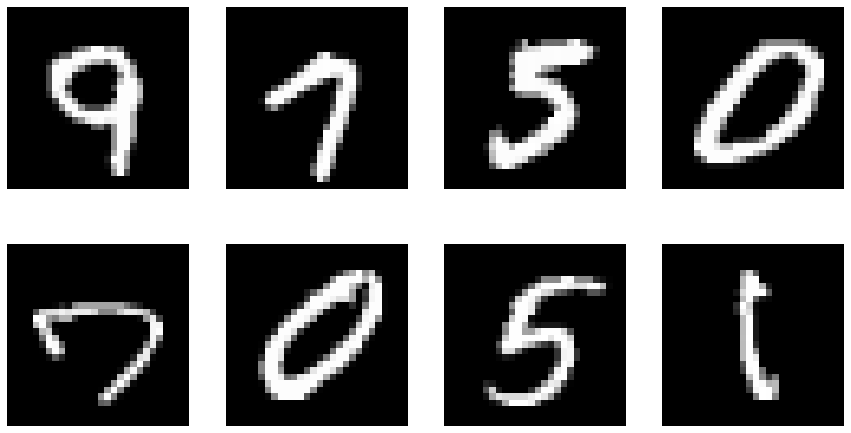

In [6]:
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(2, 4)

index = 0
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(images[index].numpy().squeeze(), cmap="gray")
        axs[i][j].axis('off')
        index += 1

## Defining model

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(OrderedDict([
                ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=4, padding=1)),
                ('relu1', nn.ReLU()),
                ('maxpool1', nn.MaxPool2d(kernel_size=2)),
                ('conv2', nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, padding=1)),
                ('relu2', nn.ReLU()),
                ('maxpool2', nn.MaxPool2d(kernel_size=3)),
                ('flatten', nn.Flatten()),
                ('fc1', nn.Linear(in_features=40*3*3, out_features=150)),
                ('relu3', nn.ReLU()),
                ('fc2', nn.Linear(in_features=150, out_features=10)),
            ]))
    
    def forward(self, x):
        out = x
        out = self.net(out)
        return out

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
network = Net()
if (torch.cuda.is_available()):
    network.cuda()

optimizer = optim.SGD(network.parameters(), lr=1e-3, momentum=0.9)

### Define helper function

In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        data = data.cuda()
        target = target.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
            torch.save(network.state_dict(), './result/mnist_model.pth')
            torch.save(optimizer.state_dict(), './result/mnist_optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
log_interval = 10
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3110, Accuracy: 825/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326431
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.320519
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.320432
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.329108
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.337043
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.318265
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.304482
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.316073
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.273014
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.275710
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.288960
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.296240
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.287566
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.302268
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.302526
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.313013
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.281964
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.280559
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.276327
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.778889
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.495644
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.546931
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.694092
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.480372
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.505666
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.648416
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.600455
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.500947
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.535179
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.739102
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.698588
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.579799
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.284415
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.452977
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.495553
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.833893
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.587030
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.610820
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.558814


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.350996
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.670066
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.533302
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.338328
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.425237
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.266435
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.224197
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.279921
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.183884
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.395121
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.382958
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.238159
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.322465
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.304428
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.379463
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.410000
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.444524
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.200833
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.462550
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.427328
